---
layout: default
title: "Deep Learning - RNN - Transformer network"
categories: deeplearning
permalink: /ML48/
order: 48
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Transformer network
One of the most powerful new idea in deep learning are the **transformer networks**, sometimes called **transformers**, an architecture presented in [Vaswani et.al.2017](https://arxiv.org/abs/1706.03762) that has mostly taken over in NLP.

The complexity of architectures increase with the complexity of tasks. RNNs have problems with long-range dependencies and so, GRUs and LSTMs address those issues at the cost of an increased complexity.

RNNs, GRUs and LSTMs are **sequential**, meaning that in order to process information at time step $t$, you necessarily have to process all preceding time steps $t^{\langle 0 \rangle}, \dots, t^{\langle t-1 \rangle}$. Transformers address this problem by introducing **parallelization**, so that a sequence is injested all at the same time rather than one step at a time.

Transformers combine the Attention model with CNNs and are based on two main processes:

* **Self-Attention** produces attention based representations $A^{\langle t \rangle}$ for all elements in a sequence
* **Multi-Head Attention** repeats the self-attention process generating multiple versions of the time-steps representations

## Self-Attention
Suppose we have a machine translation task and the input sentence

```
Jane visite l'Afrique en septembre
```

The self-attention mechanism builds an attention-based vector representation for each word in the input sentence $A^{\langle t \rangle}$. Each of these representations is a **context-dependent embedding** of a word and they are all computed in parallel. A self-attention representation $A^{\langle t \rangle}$ is computed as

$$
A(q, K, V) = \sum_i \frac{\exp \left( q \cdot k^{\langle i \rangle}\right)}
{\sum_j \exp \left( q \cdot k ^{\langle j \rangle} \right) }v^{\langle i \rangle}
$$

where $q^{\langle t \rangle}, k^{\langle t \rangle}, v^{\langle t \rangle}$, called the **query**, **key** and **value**, are vectors that are used as input to compute the self-attention representation for each word. These vectors are named using a loose analogy the queries and key-value pairs concepts in databases.

Let's build the self-attention representation for the third word $A^{\langle 3 \rangle}$ `l'Afrique` (<a href="#fig:selfattention">figure below</a>)

1. Each word is associated with its query, key, and value vectors, which are defined as
    $$
    \begin{equation}
    \begin{split}
    &q^{\langle 3 \rangle}=W^Qx^{\langle 3 \rangle}\\
    &k^{\langle 3 \rangle}=W^Kx^{\langle 3 \rangle}\\
    &v^{\langle 3 \rangle}=W^Vx^{\langle 3 \rangle}
    \end{split}
    \end{equation}
    \label{eq:qkv} \tag{1}
    $$
    where $W^Q, W^K, W^V$ are learned parameter matrices of the algorithm. The query vector $q^{\langle 3 \rangle}$ represents a question about word $x^{\langle 3 \rangle}$ (`l'Afrique`). For example, it may represent the question "*what's happening there?*"

2. The inner product of $q^{\langle 3 \rangle}$ with the key vector of each word $K$ is computed. Each of these inner products tells how good is $x^{\langle t \rangle}$ as an answer to $q^{\langle 3 \rangle}$. For intuition purpose if $k^{\langle 1 \rangle}$ represents a *person* (`Jane`) and $k^{\langle 2 \rangle}$ represents an *action* (`visite`), then you may find that $\left \langle q^{\langle 3 \rangle}, k^{\langle 2 \rangle} \right \rangle$ has the largest value and that `visite` gives the most relevant context to *what is happening in Africa*. Since this step is computing the inner product, it is actually scanning for the key $k$ vector, which is **most similar to the query** vector $q$.

3. The softmax of all the inner products $\left \langle q^{\langle 3 \rangle}, k^{\langle j \rangle} \right \rangle$ is computed

4. The softmax vector is multiplied with the value vector $V$

5. By summing over all values of vector $V$, we obtain $A^{\langle 3 \rangle}$, which can be also written as 

$$
A^{\langle 3 \rangle } = A \left( q^{\langle 3 \rangle }, K, V\right) 
$$

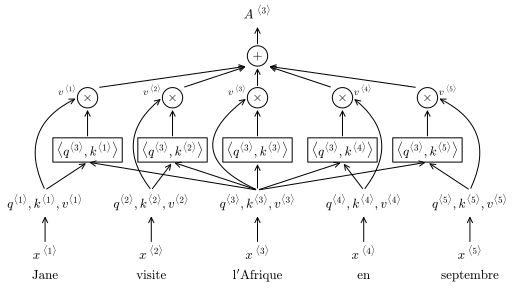

In [2]:
f = Flow(bbox=dict(boxstyle='square', ec='none'), figsize=(8, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)

for i, (w, displ) in enumerate(zip(sentence, (np.arange(1, len(sentence)+1)-3)/5)):
    f.node(f'x{i+1}', startpoint=f'x{i}', label=label('x', i+1), connect=False)
    f.node(f'w{i+1}', distance=.4, startpoint=f'x{i+1}', label=f'$\\mathrm{{{w}}}$', 
           connect=False, travel='s')
    f.node(f'qkv{i+1}', travel='n', startpoint=f'x{i+1}',
           label=f'$q^{{\\langle {i+1} \\rangle}}, k^{{\\langle {i+1} \\rangle}},v^{{\\langle {i+1} \\rangle}}$')
    f.node(f'ip{i+1}', travel='nw', distance=(displ, 1), bbox=dict(ec='k'),
           label=f'$\\left \\langle q^{{\\langle 3 \\rangle}}, k^{{\\langle {i+1} \\rangle}} \\right \\rangle$', 
           edge_kwargs=dict(headport='s', tailport='n'))
    f.node(f'v{i+1}', label='$\\times$', bbox=dict(boxstyle='circle', ec='k'), travel='n',
           startpoint=f'ip{i+1}', xlabel=label('v', i+1), xlabel_xy=(-.5 if i<3 else 1.5, 0.8))

f.node('+', label='$+$', travel='n', startpoint='v3', distance=.8,
       bbox=dict(boxstyle='circle', ec='k'))
f.node('A3', label=label('A', 3), travel='n', startpoint='+', distance=.8)

for i, r in zip(range(len(sentence)), [.5, .5, .85, -.5, -.5]):
    if i !=2:
        f.edge('qkv3', f'ip{i+1}', headport='s', tailport='n')
        f.edge(f'v{i+1}', '+')
    hp = 'w' if i < 3 else 'e'
    f.edge(f'qkv{i+1}', f'v{i+1}', tailport='n', headport=hp, 
           arrowprops=dict(connectionstyle=f'arc3,rad={r}'))

<i id="fig:selfattention">Self attention mechanism for the computation of the self-attention representation $A^{\langle 3 \rangle}$. A set of query, key, value vectors ($q, k, v$) are learned for each word $x$. The best context-dependent embedding is computed for the word $x^{\langle 3 \rangle}$ as the inner product of query and key $\langle q, k \rangle$. The softmax vector of the inner products is multiplied by the value vector $v$, which summed together constitutes the self-attention representation $A^{\langle 3 \rangle}$ </i>


The main advantage of the self-attention mechanism is that the embedding for the word `l'Afrique` is not fixed. The self-attention mechanism realizes that `l'Afrique` is the destination of a `visite` and thus compute a more useful and context-aware representation for this word.
    
This process is repeated for each word in the sequence to obtain self-attention representations for each of them $A^{\langle i \rangle}$, which in literature is often defined in a vectorized notation
    
$$
\text{Attention}(Q,K,V) = \text{softmax} \left ( \frac{QK^T}{\sqrt{d_k}} \right)V
$$
    
where $\sqrt{d_k}$ is the **scaled dot product** used to prevent exploding gradients, and in fact another name for this model is the **scaled dot product attention** as it is presented in the original transformer architecture paper ([Vaswani et.al.2017](https://arxiv.org/abs/1706.03762))

## Multi-Head attention
The multi-head process repeats the self attention mechanism multiple times **in parallel**. Each time we calculate self attention for a sequence it's called a **head**, thus the name multi-head attention. 

Self attention vectors are functions of $q, k, v$ vectors. In turn these vectors are obtained as defined in $\eqref{eq:qkv}$ and they are a function of the parameter matrices $W^Q, W^K, W^V$.

The parameters matrices of the first head, to which refer as $W_1^Q, W_1^K, W_1^V$ focus on asking and answering a specific question; in the example above we said that the question asked when computing $A^{\langle 3 \rangle }$ is: *What is happening there?*.

When computing the second head we will have a second set of parameter matrices $W_2^Q, W_2^K, W_2^V$, which are relative to a different question, for example it could be: *When?* , and so the largest inner product may now be $\langle q^{\langle 3 \rangle }, k^{\langle 5 \rangle } \rangle$

There will be as many heads as the number of questions asked and the number of heads is usually referred to as $h$, with a typical number of heads being 8.

The final value of the multi-head process is the concatenation of all the heads, multiplied by a parameter matrix $W_o$

$$
\text{MultiHead}(Q, K, V)=\text{concat}\left(\text{head}_1, \dots \text{head_h}\right)W_o
$$

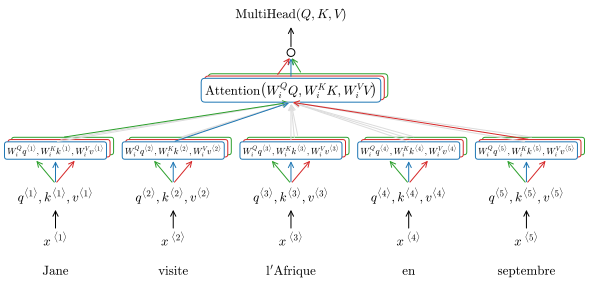

In [3]:
f = Flow(bbox=dict(boxstyle='round', ec='none'), figsize=(9, 5), fontsize=13)
sentence = "Jane visite l'Afrique en septembre".split()
label = lambda b, i: '${}^{{ \\; \\langle {} \\rangle}}$'.format(b, i)
W = lambda sup, sub, i=None: 'W_i^{}{}{}'.format(sup, sub, f'^{{\\langle {i} \\rangle}}' if i is not None else '')

for i, w in enumerate(sentence):
    f.node(f'x{i+1}', startpoint=f'x{i}', label=label('x', i+1), connect=False)
    f.node(f'w{i+1}', distance=.4, startpoint=f'x{i+1}', label=f'$\\mathrm{{{w}}}$', 
           connect=False, travel='s')
    f.node(f'qkv{i+1}', travel='n', startpoint=f'x{i+1}', distance=.6,
           label=f'$q^{{\\langle {i+1} \\rangle}}, k^{{\\langle {i+1} \\rangle}},v^{{\\langle {i+1} \\rangle}}$')
    f.node(f'W{i+1}.1', travel='n', bbox=dict(ec='C0'), fontsize=9, distance=.6, connect=False,
           label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
           edge_kwargs=dict(headport='s', tailport='n'))
    f.node(f'W{i+1}.2', travel='ne', bbox=dict(ec='C3'), fontsize=9, distance=.03,
           label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
           connect=False, startpoint=f'W{i+1}.1', zorder=-10)
    f.node(f'W{i+1}.3', travel='ne', bbox=dict(ec='C2'), fontsize=9, distance=.03,
       label='${}$'.format(','.join([W('Q', 'q', i+1), W('K', 'k', i+1), W('V','v', i+1)])), 
       connect=False, startpoint=f'W{i+1}.2', zorder=-20)
    

f.node('A.1',
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.1', distance=.8, connect=False,
       bbox=dict(ec='C0'))
f.node('A.2', zorder=-10,
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.2', distance=.8, connect=False,
       bbox=dict(ec='C3'))
f.node('A.3', zorder=-20,
       label='$\mathrm{{Attention}}\\left({}\\right)$'.format(','.join([W('Q', 'Q'), W('K', 'K'), W('V','V')])), 
       travel='n', startpoint='W3.3', distance=.8, connect=False,
       bbox=dict(ec='C2'))
f.node('+', label=' ', fontsize=5, bbox=dict(boxstyle='circle', ec='k'), travel='n', 
       distance=.5, connect=False, startpoint='A.1')
f.node('MH', label='$\\mathrm{{MultiHead}}(Q, K, V)$', 
       travel='n', startpoint='+', distance=.5)
f.edge('A.1', '+', arrowprops=dict(ec='C0'), tailport='n')
f.edge('A.2', '+', arrowprops=dict(ec='C3'), tailport=(0.4, 1), headport='s')
f.edge('A.3', '+', arrowprops=dict(ec='C2'), tailport=(0.52, 1), headport='s')
    
for i in range(len(sentence)):
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C0'))
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C2'), headport=(0.3, 0))
    f.edge(f'qkv{i+1}', f'W{i+1}.1', arrowprops=dict(ec='C3'), headport=(0.7, 0))

    if i != 1:
        f.edge(f'W{i+1}.1', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i != 4:
        f.edge(f'W{i+1}.2', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i != 0:
        f.edge(f'W{i+1}.3', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='gainsboro'))
    if i == 1:
        f.edge(f'W{i+1}.1', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C0'))
    if i == 4:
        f.edge(f'W{i+1}.2', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C3'))
    if i == 0:
        f.edge(f'W{i+1}.3', 'A.1', headport='s', tailport='n',
               arrowprops=dict(ec='C2'))

<i id="fig:multihead">Processing of multiple heads (self-attention mechanisms). Multiple context-dependent embeddings (self-attention representations or heads) are computed in parallel to answer different queries $q$. The heads are then concatenated in the final output</i>

The different heads are independent computations and can thus be calculated **in parallel**; after the computation of all the heads is completed, the self-attention vectors are concatenated and multiplied by a parameter matrix $W_o$.